# P4

## Exploratory Data Analysis

In [1]:
import pandas as pd
import pandasql as psql
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
customers = pd.read_csv('dataset/olist_customers_dataset.csv')
# geolocation = pd.read_csv('dataset/olist_geolocation_dataset.csv')
order_items = pd.read_csv('dataset/olist_order_items_dataset.csv')
order_payments = pd.read_csv('dataset/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('dataset/olist_order_reviews_dataset.csv')
orders = pd.read_csv('dataset/olist_orders_dataset.csv')
products = pd.read_csv('dataset/olist_products_dataset.csv')
sellers = pd.read_csv('dataset/olist_sellers_dataset.csv')
# product_category_name = pd.read_csv('dataset/product_category_name_translation.csv')


In [3]:
olist = orders.merge(order_items, on='order_id', how='left')
olist = olist.merge(order_payments, on='order_id', how='outer', validate='m:m')
olist = olist.merge(order_reviews, on='order_id', how='outer')
olist = olist.merge(products, on='product_id', how='outer')
olist = olist.merge(customers, on='customer_id', how='outer')
olist = olist.merge(sellers, on='seller_id', how='outer')

In [4]:
olist

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,2018-07-01 10:23:10,2018-07-05 16:17:52,2018-07-04 14:34:00,2018-07-09 15:06:57,2018-07-20 00:00:00,1.0,31ec3a565e06de4bdf9d2a511b822b4d,...,30.0,28.0,28.0,2077f7ec37df79c62cc24b7b8f30e8c9,8528,ferraz de vasconcelos,SP,13660.0,porto ferreira,SP
119139,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaN,NaN,2017-03-30 00:00:00,1.0,241a1ffc9cf969b27de6e72301020268,...,16.0,4.0,11.0,78a159045124eb7601951b917a42034f,89111,gaspar,SC,89031.0,blumenau,SC
119140,735dce2d574afe8eb87e80a3d6229c48,d531d01affc2c55769f6b9ed410d8d3c,delivered,2018-07-24 09:46:27,2018-07-24 11:24:27,2018-07-24 15:14:00,2018-08-02 22:47:35,2018-08-16 00:00:00,1.0,1d187e8e7a30417fda31e85679d96f0f,...,80.0,8.0,30.0,8cf3c6e1d2c8afaab2eda3fa01d4e3d2,60455,fortaleza,CE,13478.0,americana,SP
119141,25d2bfa43663a23586afd12f15b542e7,9d8c06734fde9823ace11a4b5929b5a7,delivered,2018-05-22 21:13:21,2018-05-22 21:35:40,2018-05-24 12:28:00,2018-06-12 23:11:29,2018-06-08 00:00:00,1.0,6e1c2008dea1929b9b6c27fa01381e90,...,41.0,21.0,41.0,e55e436481078787e32349cee9febf5e,39803,teofilo otoni,MG,8320.0,sao paulo,SP


In [5]:
olist['order_delivered_carrier_date'] = pd.to_datetime(olist['order_delivered_carrier_date'])
olist['order_delivered_customer_date'] = pd.to_datetime(olist['order_delivered_customer_date'])
olist['order_estimated_delivery_date'] = pd.to_datetime(olist['order_estimated_delivery_date'])
olist['shipping_limit_date'] = pd.to_datetime(olist['shipping_limit_date'])
olist['review_creation_date'] = pd.to_datetime(olist['review_creation_date'])
olist['order_purchase_timestamp'] = pd.to_datetime(olist['order_purchase_timestamp'])
olist['order_approved_at'] = pd.to_datetime(olist['order_approved_at'])

In [6]:
olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


In [7]:
# psql.sqldf('select * from olist where customer_id = "9ef432eb6251297304e76186b10a928d"')

In [8]:
olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              118966 non-null  datetime64[ns]
 5   order_delivered_carrier_date   117057 non-null  datetime64[ns]
 6   order_delivered_customer_date  115722 non-null  datetime64[ns]
 7   order_estimated_delivery_date  119143 non-null  datetime64[ns]
 8   order_item_id                  118310 non-null  float64       
 9   product_id                     118310 non-null  object        
 10  seller_id                      118310 non-null  object        
 11  

In [9]:
olist[olist['customer_id'].duplicated()]['customer_id']

1         9ef432eb6251297304e76186b10a928d
2         9ef432eb6251297304e76186b10a928d
15        f6c383cc79b182ce1550bc57504941c3
23        8860eda9f0c775c17cf854564eab3418
39        d27812f504d4415e126b6fba33f631d0
                        ...               
119120    8fdfa85118487910ecb24477b00c6ae3
119124    18df50d79545e4b86e36986c7271156b
119132    7795e3faa6e16fc40aafee568b25a85d
119135    5a1470d43d8ad960d4199134d3df48e0
119137    c0c8b8bb055100a0cc08dcc04d847ac9
Name: customer_id, Length: 19702, dtype: object

In [10]:
# todo : feature engineering
# product size : h x l x L en catégories S M L XL
# nb de type de paiements par commande : voucher +| card 

<AxesSubplot:ylabel='None'>

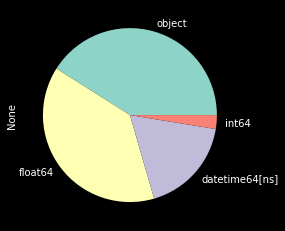

In [11]:
olist.dtypes.value_counts().plot.pie()

In [12]:
olist.select_dtypes("float")

,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix
0,1.0,29.99,8.72,1.0,1.0,18.12,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0
1,1.0,29.99,8.72,3.0,1.0,2.00,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0
2,1.0,29.99,8.72,2.0,1.0,18.59,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0
3,1.0,29.99,7.78,1.0,3.0,37.77,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0
4,1.0,29.99,7.78,1.0,1.0,37.77,5.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,1.0,79.00,14.13,1.0,1.0,93.13,5.0,40.0,516.0,2.0,750.0,30.0,28.0,28.0,13660.0
119139,1.0,19.70,10.96,1.0,1.0,30.66,1.0,48.0,260.0,2.0,400.0,16.0,4.0,11.0,89031.0
119140,1.0,399.00,45.07,1.0,1.0,444.07,5.0,43.0,729.0,2.0,2100.0,80.0,8.0,30.0,13478.0
119141,1.0,219.90,24.12,1.0,4.0,244.02,4.0,19.0,531.0,1.0,5900.0,41.0,21.0,41.0,8320.0


In [13]:
olist.select_dtypes("object")

,order_id,customer_id,order_status,product_id,seller_id,payment_type,review_id,review_comment_title,review_comment_message,review_answer_timestamp,product_category_name,customer_unique_id,customer_city,customer_state,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,credit_card,a54f0611adc9ed256b57ede6b6eb5114,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-12 03:43:48,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,voucher,a54f0611adc9ed256b57ede6b6eb5114,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-12 03:43:48,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,voucher,a54f0611adc9ed256b57ede6b6eb5114,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-12 03:43:48,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,credit_card,b46f1e34512b0f4c74a72398b03ca788,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-20 15:16:36,utilidades_domesticas,3a51803cc0d012c3b5dc8b7528cb05f7,sao paulo,SP,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,credit_card,dc90f19c2806f1abba9e72ad3c350073,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 23:26:23,utilidades_domesticas,ef0996a1a279c26e7ecbd737be23d235,sao paulo,SP,maua,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,31ec3a565e06de4bdf9d2a511b822b4d,babcc0ab201e4c60188427cae51a5b8b,boleto,7f9849fcbfdf9fa3070c05b5501bf066,NaN,NaN,2018-07-10 18:32:29,construcao_ferramentas_iluminacao,2077f7ec37df79c62cc24b7b8f30e8c9,ferraz de vasconcelos,SP,porto ferreira,SP
119139,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,241a1ffc9cf969b27de6e72301020268,8501d82f68d23148b6d78bb7c4a42037,credit_card,c950324a42c5796d06f569f77d8b2e88,NaN,NaN,2017-04-01 10:24:03,automotivo,78a159045124eb7601951b917a42034f,gaspar,SC,blumenau,SC
119140,735dce2d574afe8eb87e80a3d6229c48,d531d01affc2c55769f6b9ed410d8d3c,delivered,1d187e8e7a30417fda31e85679d96f0f,d263fa444c1504a75cbca5cc465f592a,debit_card,19f21ead7ffe5b1b5147a7877c22bae5,NaN,NaN,2018-08-04 11:22:40,moveis_decoracao,8cf3c6e1d2c8afaab2eda3fa01d4e3d2,fortaleza,CE,americana,SP
119141,25d2bfa43663a23586afd12f15b542e7,9d8c06734fde9823ace11a4b5929b5a7,delivered,6e1c2008dea1929b9b6c27fa01381e90,edf3fabebcc20f7463cc9c53da932ea8,credit_card,ec2817e750153dfdd61894780dfc5d9e,NaN,NaN,2018-06-13 09:17:47,moveis_decoracao,e55e436481078787e32349cee9febf5e,teofilo otoni,MG,sao paulo,SP


In [14]:
olist.select_dtypes("datetime")

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,review_creation_date
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,2017-10-11
1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,2017-10-11
2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,2017-10-11
3,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,2017-08-21 20:05:16,2017-08-19
4,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,2017-08-08 18:37:31,2017-08-08
...,...,...,...,...,...,...,...
119138,2018-07-01 10:23:10,2018-07-05 16:17:52,2018-07-04 14:34:00,2018-07-09 15:06:57,2018-07-20,2018-07-10 08:32:33,2018-07-10
119139,2017-03-11 19:51:36,2017-03-11 19:51:36,NaT,NaT,2017-03-30,2017-03-16 19:51:36,2017-04-01
119140,2018-07-24 09:46:27,2018-07-24 11:24:27,2018-07-24 15:14:00,2018-08-02 22:47:35,2018-08-16,2018-07-30 11:24:27,2018-08-03
119141,2018-05-22 21:13:21,2018-05-22 21:35:40,2018-05-24 12:28:00,2018-06-12 23:11:29,2018-06-08,2018-05-28 21:31:24,2018-06-10


In [15]:
olist.select_dtypes("int")

,customer_zip_code_prefix
0,3149
1,3149
2,3149
3,3366
4,2290
...,...
119138,8528
119139,89111
119140,60455
119141,39803


In [16]:
olist.select_dtypes("timedelta")

""
0
1
2
3
4
...
119138
119139
119140
119141


In [17]:
olist.select_dtypes("category")

""
0
1
2
3
4
...
119138
119139
119140
119141


In [18]:
olist['order_status'].value_counts()

delivered      115723
shipped          1256
canceled          750
unavailable       652
invoiced          378
processing        376
created             5
approved            3
Name: order_status, dtype: int64

### Univariate & Multivariate Analysis

In [19]:
def dropOutlierIQR(df, col):
    Q1 = df[col].quantile(0.25)
    # print(Q1)
    Q3 = df[col].quantile(0.75)
    # print(Q3)
    IQR = Q3 - Q1
    # print(IQR)
    df[col] = df[col][df[col].between((Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR))]


<AxesSubplot:>

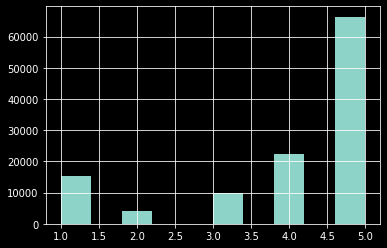

In [20]:
olist['review_score'].hist()

<AxesSubplot:ylabel='review_score'>

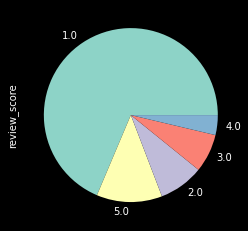

In [21]:
canceled = olist[olist['order_status'] == "canceled"]
canceled['review_score'].value_counts().plot.pie()

<AxesSubplot:>

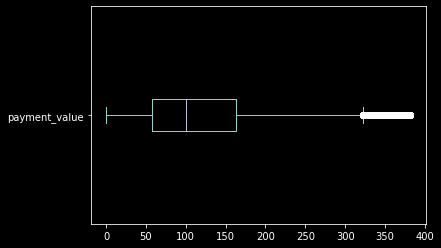

In [22]:
# we consider the payment value feature is very important in the analysis, so we should restrict to the most probable values, thus we remove outliers an nans
dropOutlierIQR(olist, 'payment_value')
olist['payment_value'].plot.box(vert=False)

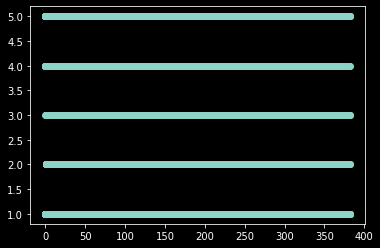

In [23]:
plt.scatter(olist['payment_value'], olist['review_score'])

In [24]:
olist_bak = olist.copy()

## Features Engineering & Cleaning

In [25]:
# we can remove some features that we won't use for sure
olist.drop('review_comment_message', axis=1, inplace=True)   # we don't do sentiment analysis
olist.drop('customer_unique_id', axis=1, inplace=True)       # duplicates customer_id
olist.drop('payment_sequential', axis=1, inplace=True)
olist.drop('payment_installments', axis=1, inplace=True)
olist.drop('product_name_lenght', axis=1, inplace=True)
olist.drop('product_description_lenght', axis=1, inplace=True)
olist.drop('review_comment_title', axis=1, inplace=True)
olist.drop('review_id', axis=1, inplace=True)
olist.drop('order_item_id', axis=1, inplace=True)


olist.dropna(inplace=True)


### Product Size and Weight 

In [26]:
#  product size category

olist['product_volume'] = olist['product_length_cm'] * olist['product_height_cm'] * olist['product_width_cm']

slices = ['XS', 'S', 'M', 'L', 'XL', 'XXL']

c, bins = pd.qcut(olist['product_volume'], len(slices), labels=slices, retbins=True)
# print(c.value_counts())
olist['product_volume']=c.values

c, bins = pd.qcut(olist['product_weight_g'], len(slices), labels=slices, retbins=True)
# print(c.value_counts())
olist['product_weight'] = c.values


olist.drop('product_length_cm', axis=1, inplace=True)
olist.drop('product_height_cm', axis=1, inplace=True)
olist.drop('product_width_cm', axis=1, inplace=True)
olist.drop('product_weight_g', axis=1, inplace=True)

# olist.groupby('product_volume').size().plot(kind='pie', autopct='%.2f')



<AxesSubplot:xlabel='product_volume'>

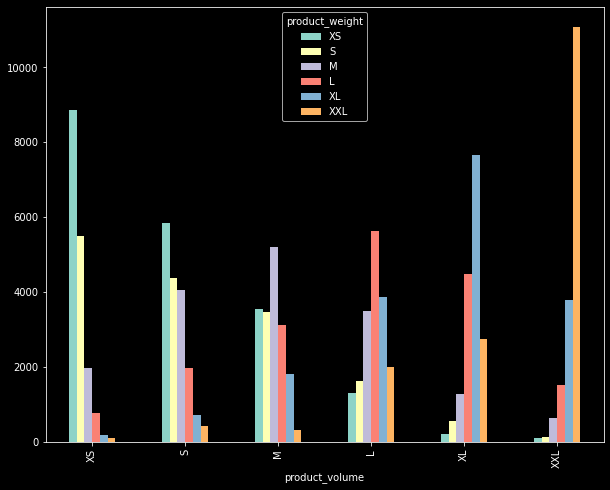

In [27]:

pd.crosstab(olist['product_volume'], olist['product_weight']).plot(kind='bar', stacked=False, figsize=(10,8))

<AxesSubplot:xlabel='product_weight'>

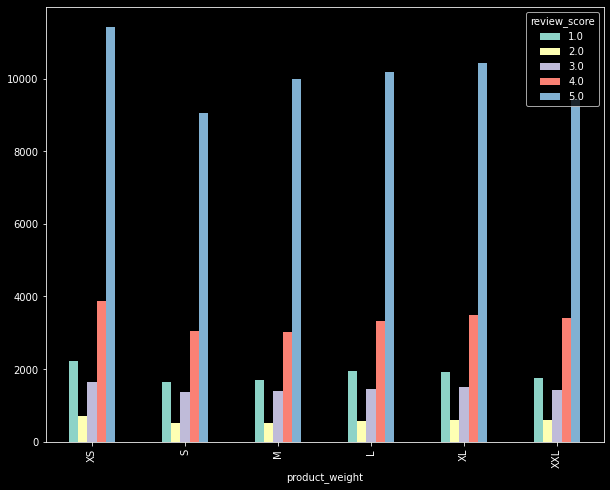

In [28]:
pd.crosstab(olist['product_weight'], olist['review_score']).plot(kind='bar', stacked=False, figsize=(10,8))

<AxesSubplot:xlabel='product_volume'>

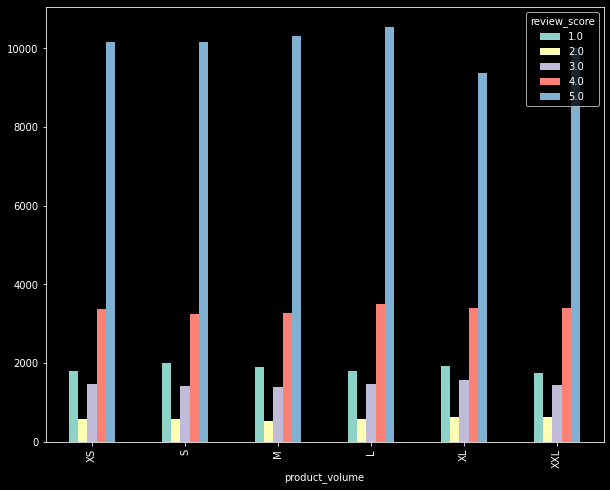

In [29]:
pd.crosstab(olist['product_volume'], olist['review_score']).plot(kind='bar', stacked=False, figsize=(10,8))

### Order timestamps & delays

In [30]:
olist['payment_approval_ellapse'] = olist['order_approved_at'] - olist['order_purchase_timestamp']
olist['delivery_precision'] = olist['order_delivered_customer_date'] - olist['order_delivered_carrier_date']
olist['delivery_lag'] = olist['order_delivered_customer_date'] - olist['order_estimated_delivery_date']
olist['delivery_after_purchase'] = olist['order_delivered_customer_date'] - olist['order_purchase_timestamp']
olist['review_hurry'] = olist['review_creation_date'] - olist['order_delivered_customer_date']

olist.drop('order_approved_at', axis=1, inplace=True)
olist.drop('order_purchase_timestamp', axis=1, inplace=True)
olist.drop('order_delivered_customer_date', axis=1, inplace=True)
olist.drop('order_delivered_carrier_date', axis=1, inplace=True)
olist.drop('order_estimated_delivery_date', axis=1, inplace=True)
olist.drop('review_creation_date', axis=1, inplace=True)
olist.drop('shipping_limit_date', axis=1, inplace=True)	  # don't need this one
olist.drop('review_answer_timestamp', axis=1, inplace=True)	  # don't need this one ?? TODO check


In [31]:
#  convert timedeltas into float -> delays are in hours
for col in olist.select_dtypes("timedelta").columns:
	olist[col] = olist[col] / np.timedelta64(1, 'h')

In [32]:
olist.select_dtypes(["float","int"])

,price,freight_value,payment_value,review_score,product_photos_qty,customer_zip_code_prefix,seller_zip_code_prefix,payment_approval_ellapse,delivery_precision,delivery_lag,delivery_after_purchase,review_hurry
0,29.99,8.72,18.12,4.0,4.0,3149,9350.0,0.178333,145.503611,-170.579722,202.477778,2.579722
1,29.99,8.72,2.00,4.0,4.0,3149,9350.0,0.178333,145.503611,-170.579722,202.477778,2.579722
2,29.99,8.72,18.59,4.0,4.0,3149,9350.0,0.178333,145.503611,-170.579722,202.477778,2.579722
3,29.99,7.78,37.77,4.0,4.0,3366,9350.0,1.595833,23.269444,-225.254722,68.253333,9.254722
4,29.99,7.78,37.77,5.0,4.0,2290,9350.0,0.307778,72.905000,-173.499722,120.087222,5.499722
...,...,...,...,...,...,...,...,...,...,...,...,...
119134,44.99,22.25,134.48,5.0,2.0,39810,88490.0,0.179722,182.375278,-211.724722,247.032222,-4.275278
119135,44.99,22.25,134.48,5.0,2.0,39810,88490.0,0.179722,182.375278,-211.724722,247.032222,-4.275278
119138,79.00,14.13,93.13,5.0,2.0,8528,13660.0,101.911667,120.549167,-248.884167,196.729722,8.884167
119141,219.90,24.12,244.02,4.0,1.0,39803,8320.0,0.371944,466.724722,119.191389,505.968889,-71.191389


In [48]:
assert olist[olist.isna().any(axis=1)].shape[0] == 0

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# todo remove outliers of product_size

dropOutlierIQR(olist, 'product_volume')

ct = make_column_transformer(
	(MinMaxScaler(), ['product_volume']),
	(StandardScaler(), ['product_volume'])
)

pipe = Pipeline([
	('mm', MinMaxScaler()),
	('ss', StandardScaler()),
	])


col_transformer = ColumnTransformer(
                    transformers=[('nums', pipe, ['product_volume'])],
                    remainder='drop',
                    n_jobs=-1
                    )
cl = col_transformer.fit_transform(olist)
pd.DataFrame(cl).describe()


# ct = ColumnTransformer([
#         ('somename', StandardScaler(), ['product_size'])
#     ], remainder='passthrough')

# cc  = ct.fit_transform(olist)
# pd.DataFrame(cc).describe()

# olist['product_size_std'] = cc
# olist['product_size_std'].describe()


TypeError: unsupported operand type(s) for -: 'str' and 'str'